# ЗАДАНИЕ ПО ВЫЧМАТАМ
# ВАРИАНТ 7.5. Численное решение жесткой системы

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.interactive import printing
printing.init_printing(use_latex=True)

# Суточные колебания концентрации озона в атмосфере
# Рассмотрим простейшую математическую модель колебаний концентрации озона в атмосфере
# Она описывается следующей неавтономной системой ОДУ

In [127]:
y1 = sp.Symbol('y1')
y2 = sp.Symbol('y2')
y3 = sp.Symbol('y3')
t = sp.Symbol('t')
k1 = sp.Symbol('k1')
k2 = sp.Symbol('k2')
k3 = sp.Symbol('k3')
k4 = sp.Symbol('k4')
omega = sp.Symbol('ω')
c3 = sp.Symbol('c3')
c4 = sp.Symbol('c4')
y1_0 = sp.Symbol('y1_0')
y2_0 = sp.Symbol('y2_0')
y3_0 = sp.Symbol('y3_0')  # определяем переменные LaTex
dydt_1 = sp.Function('y1')(y1,y2,y3,t)
dydt_2 = sp.Function('y2')(t)
dydt_3 = sp.Function('y3')(y1,y2,y3,t)  # определяем функции LaTex (уравнения системы)
dydt_1 = dydt_1.diff(t)
dydt_2 = dydt_2.diff(t)
dydt_3 = dydt_3.diff(t)  # вид dy/dt

In [126]:
def kineq(y1, y2, y3, k1, k2, k3, k4):  # функция доступа к уравнениям системы kinetic equation
    dydt_1 = -k1*y1*y2 - k2*y1*y3 + 2*k3*y2 + k4*y3
    dydt_2 = 0  # O2 вообще не считаем
    dydt_3 = k1*y1*y2 - k2*y1*y3 - k4*y3
    return {1:dydt_1, 2: dydt_2, 3:dydt_3}

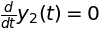

In [66]:
display(sp.Eq(dydt_1, kineq(y1, y2, y3, k1, k2, k3, k4)[1]))
display(sp.Eq(dydt_2, kineq(y1, y2, y3, k1, k2, k3, k4)[2]))
display(sp.Eq(dydt_3, kineq(y1, y2, y3, k1, k2, k3, k4)[3]))

# Определим параметры системы, начальные условия
# Параметры k3, k4 пока покажем оценочно, для представления картины

In [134]:
sp.Eq(omega,np.pi/43200), \
sp.Eq(k1,1.63e-16), \
sp.Eq(k2,4.66e-16), \
sp.Eq(k3, 0), \
sp.Eq(c3,22.62), \
sp.Eq(c4,7.601), \
sp.Eq(y1_0,1e6), \
sp.Eq(y2_0,3.7e16), \
sp.Eq(y1_0,1e12)  # вид, показано до определения

# Система умеренно жесткая днем

In [148]:
'k3 = 0, так и не хватило света',\
'k4 = array([5.03000000e+00, 5.06000000e+00, 5.09000000e+00, ..., \
        1.11149793e+06, 1.11316242e+06, 1.11482895e+06])'

('k3 = 0, так и не хватило света',
 'k4 = array([5.03000000e+00, 5.06000000e+00, 5.09000000e+00, ...,         1.11149793e+06, 1.11316242e+06, 1.11482895e+06])')

In [149]:
omega = np.pi/43200  # частота колебаний, c-1
k1, k2 = 1.63e-16, 4.66e-16  # константы скорости
c3, c4 = 22.62, 7.601  # константы дневных колебаний функции exp(-c/sin(wt)), функция определяет зависимость \ 
# k3 и k4 от времени

In [150]:
t = np.arange(0, 8084, 1)  # точки времени, возьмем небольшое время с шагом в 100 с
def light_dep(w, c, m):  # функция определения k3 и k4, зависимость от дневных колебаний, возвращает массив
    res = np.arange(0)
    for _ in t:
        if np.sin(w*_) <= 0.0:  # 
            continue
        elif round(np.exp(-c/np.sin(w*_))*m):  # округляем тысячные доли до нуля в сравнении с остальными членами y 
            res = np.append(res, round(np.exp(-c/np.sin(w*_))*10*m, 2))  
    if not res.size>0:
        res = 0  # если так и не было света (или слишком мало, округлили)
    return res

In [151]:
k3, k4 = light_dep(omega, c3, 1e15), light_dep(omega, c4, 1e11)  # округлили до -17 и -13 соответсвенно

In [152]:
y1_0, y2_0, y3_0 = 1e6, 3.7e16, 1e12  # начальные концентрации, см-3 

# Реализуем схему Розенброка CROS
# 1. Получим численное решение, шаг возьмем из других методов
# 2. Построим график решения

# Описание CROS

In [207]:
y_n = sp.Symbol('Yn')
h = sp.Symbol('h')
t = sp.Symbol('t')
re_w = sp.Symbol('Rew')
e = sp.Symbol('E')
j = sp.Symbol('J') 
gamma = sp.Symbol('γ')
w = sp.Symbol('w')
t0 = sp.Symbol('t0')
y0 = sp.Symbol('y0')
alpha = sp.Symbol('α')
y_n1 = sp.Function('Yn+1')(t)
x = sp.Function('')(t0+alpha*h)
f = sp.Function('f')(x, y0)

In [208]:
display(sp.Eq((e - gamma*h*j)*w, f))  # одностадийная схема Розенброка первого порядка аппроксимации, \
# L1 устойчивость, b = 1
display(sp.Eq(y_n1, y_n + h*re_w))  # итерационное решение 

In [210]:
gamma = 0.5 + 0.5j  # выберем гамма для L2, Reγ = 1/2
display(sp.Eq((e - gamma*h*j)*w, f.subs(alpha,0.5)))  # одностадийная схема Розенброка второго \
# порядка аппроксимации, L2 устойчивость, α = Reγ = 1/2
display(sp.Eq(y_n1, y_n + h*re_w))  # итерационное решение 

# Функция устойчивости CROS (h^2)

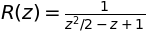

In [212]:
z = sp.Symbol('z')
r_z = sp.Function('R')(z)
display(sp.Eq(r_z, 1/(1 - z + (z**2)/2)))

# Построим матрицу Якоби системы ОДУ для начальных условий

In [213]:
vars = sp.symbols('y1 y2 y3') # определение переменных
f = sp.sympify(['-k1*y1*y2 - k2*y1*y3 + 2*k3*y2 + k4*y3', '0', 'k1*y1*y2 - k2*y1*y3 - k4*y3']) # определение функции
jacoby = sp.zeros(len(f),len(vars)) # создание матрицы нулей с зависимостью f(y)

In [214]:
# заполнение матрицы, теперь это м Якоби 
for i, fi in enumerate(f):
     for j, s in enumerate(vars):
            jacoby[i,j] = sp.diff(fi, s)
display(jacoby)  # вид

⎡-k₁⋅y₂ - k₂⋅y₃  -k₁⋅y₁ + 2⋅k₃  -k₂⋅y₁ + k₄⎤
⎢                                          ⎥
⎢      0               0             0     ⎥
⎢                                          ⎥
⎣k₁⋅y₂ - k₂⋅y₃       k₁⋅y₁      -k₂⋅y₁ - k₄⎦

In [215]:
def float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4):  #  к сожалению, заполнить матрицу числами оказалось не так просто
    values = []
    values.append(-k1*y2_0 - k2*y3_0)  #11
    values.append(-k1*y1_0 + 2*k3)  #12
    values.append(-k2*y1_0 + k4)  #13
    values.append(0)  #21
    values.append(0)  #22
    values.append(0)  #23
    values.append(k1*y2_0 - k2*y3_0)  #31
    values.append(k1*y1_0)  #32
    values.append(-k2*y1_0 - k4)  #33
    return values  # заполняем вручную

In [219]:
j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4))  \
# Якоби в y0 с числами, финальный показательный вариант, там лежат k4(t), надо будет перевычислять j \
# каждый раз, как и kineq[n]
display(j)  # вид

⎡-6.031466  -1.63e-10                                                         
⎢                                                                             
⎢    0          0                                                             
⎢                                                                             
⎣6.030534   1.63e-10   [-5.030000000466  -5.060000000466  -5.090000000466  -5.

                                                                              
                                                                              
                                                                              
                                                                              
120000000466  -5.150000000466  -5.180000000466  -5.220000000466  -5.2500000004

                                                                              
                                                                              
                                                  

# Составим уравнение схемы

In [226]:
gamma = (1+1j)/2
t0 = 0
h = 10  # шаг
t_end = 172800
e = sp.eye(3)  # E matrix
k3, k4 = 1e-15, 1e-12
j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4)) \
# 2 строки выше - антикраш ImmutableDenseDim (не работает с array), а так там массив
matr = e - gamma*h*j  # a(t) для уравнения a(t)w = f(y0(k(t)))

In [227]:
display(matr) # вид

⎡31.15733 + 30.15733⋅ⅈ   8.1499e-10 + 8.1499e-10⋅ⅈ     2.325e-9 + 2.325e-9⋅ⅈ  
⎢                                                                             
⎢          0                         1                           0            
⎢                                                                             
⎣-30.15267 - 30.15267⋅ⅈ   -8.15e-10 - 8.15e-10⋅ⅈ    1.000000002335 + 2.335e-9⋅

 ⎤
 ⎥
 ⎥
 ⎥
ⅈ⎦

# Реализация

In [295]:
t = np.linspace(t0, t_end+1, t_end//h)  # задаем значения Ох, шаг h
def rosenbrock(func):  # чудеса реализации; сделаем функцию декоратор для функции задания k3, k4 \
                       #с функцией выбора уравнения выбором поведения функции задания k3, k4
    def especially_for_row_num(row_num):  # with love
        kost = 0  # счетчик для фиксации времени для работы light_dep
        row_num = func(omega, c4, t, row_num)
        assert row_num == 1 or 3
        w = np.arange(0)
        if row_num == 1:
            init_y = y1_0  # выбор y0
        else:
            init_y = y3_0
        y_n = np.array(init_y)  # сюда складываем решение Yn+1 = Yn + hRew, сначала y0
        for _ in np.delete(t, 0):  # нач знач уже лежит на 0 шаге
            k3 = float(func(omega, c3, t[kost]))
            k4 = float(func(omega, c4, t[kost]))
            y = kineq(y1_0, y2_0, y3_0, k1, k2 ,k3, k4)[row_num]
            j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4))
            matr = e - gamma*h*j  # переопредяляем все коэффициенты на каждом шаге \
                                  # _m*w = f(h, y0)
            if row_num!=1:
                _m = matr[6] + matr[7] + matr[8]
                # делаем "деление" на матрицу
            else:
                _m = matr[0] + matr[1] + matr[2]
            # w = np.append(w, (y)/_m); необязательный этап
            y_n = np.append(y_n, init_y + h*sp.re(float(y)/_m))  # Yn+1 = Yn + Rew, _ определят добавление h
            init_y = init_y + h*sp.re(float(y)/_m)
            kost+=1
        return y_n  # массив решений
    return especially_for_row_num # выполнение функции decorated light_dep

In [229]:
@rosenbrock
def light_dep(w, c, t, row_num=None):  # deprecated function from the very beginning - переделал
    if not row_num:
        res = np.arange(0)
        if np.sin(w*t) <= 0.0:
            res = 0
        elif round(np.exp(-c/np.sin(w*t)), 18):  
            res = np.append(res, round(np.exp(-c/np.sin(w*t)), 18))  # поставим здесь границу e-18, и так мало влияет
        if res:
            return res
        else:
            return 0
    else:
        return row_num

In [230]:
y_1 = light_dep(1)  # подождем выполнения решения y1 
y_2 = y2_0
y_3 = light_dep(3)  # подождем еще выполнения решения y3

c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [232]:
display(y_1, y_3)  # вид решений

array([1000000.0, 531.846037277835, -998936.307925444, ...,
       178208607096.393, 178207607628.239, 178206608160.085], dtype=object)

array([1000000000000.0, 999999000568.485, 999998001136.970, ...,
       1175632785611.69, 1175631786180.18, 1175630786748.66], dtype=object)

In [234]:
def oxygen(): 
    return y_1
def ozone():    # так очевиднее
    return y_3

#  Графики

In [293]:
plt.style.use('seaborn-notebook') 

Text(0, 0.5, 'концентрация ат. кислорода y1(t), см-3')

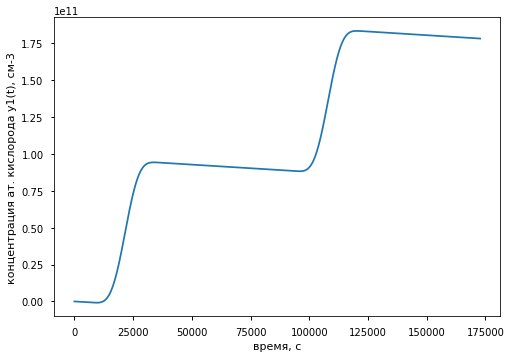

In [296]:
plt.plot(t, oxygen())  # строим кривую решения для кислорода
plt.xlabel('время, с')
plt.ylabel('концентрация ат. кислорода y1(t), см-3')

Text(0, 0.5, 'концентрация озона y3(t), см-3')

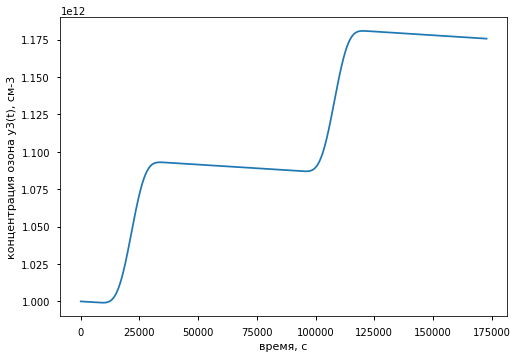

In [299]:
plt.plot(t, ozone())  # строим кривую решения для озона
# plt.scatter(t, ozone(), color='violet') - fun
plt.xlabel('время, с')
plt.ylabel('концентрация озона y3(t), см-3')

Text(0, 0.5, 'концентрация , см-3')

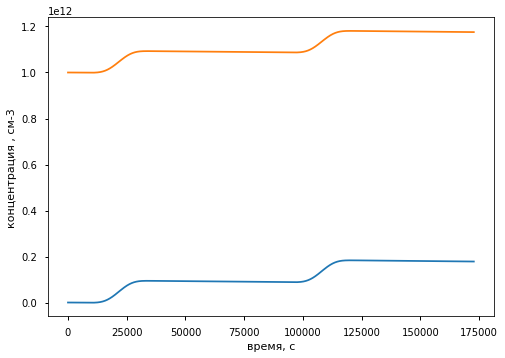

In [298]:
plt.plot(t, oxygen())
plt.plot(t, ozone())
plt.xlabel('время, с')
plt.ylabel('концентрация , см-3')  # на одном графике

# Функция устойчивости

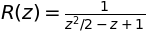

c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


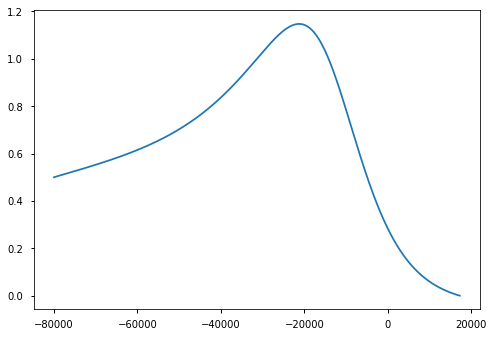

In [312]:
display(sp.Eq(r_z, 1/(1 - z + (z**2)/2)))
t = np.linspace(-80000, 17280, 1000)
z = np.linspace(0, 1, 1000) + 1j*np.linspace(0, 1, 1000)
x = [x.real for x in z]
y = [x.imag for x in z]
plt.plot(t, 1/(1 - z + (z**2))/2) 

# |z| < 1 на (-inf, 0] и стремится к нулю

# УЖЕ РУНГА

In [1]:
class Onestepmethod (object):
    def __init__(self, f, y0, t0, te, N, tol):
        self.f = f
        self.y0 = y0.astype(float)
        self.t0 = t0
        self.interval = [t0, te]
        self.grid = linspace(t0, te, N+2)
        self.h = (te-t0)/(N+1)
        self.N = N
        self.tol = tol
        self.m = len(y0)
        self.s = len(self.b)
        self.solution = None

    def step(self):
        ti, yi = self.grid[0], self.y0
        tim1 = ti
        yield np.hstack((array([ti]), yi))
        for ti in self.grid[1:]:
            yi = yi + self.h * self.phi(tim1, yi)
            tim1 = ti
            yield np.hstack((array([ti]), yi))

    def solve(self):
        self.solution = list(self.step())

    # To be implemented in a derived class
    def phi(self, tim1, yi):
        return 1

In [2]:
class RungeImplicit(Onestepmethod):
    def phi(self, t0, y0):
        M = 10
        stageDer = array(self.s*[self.f(t0,y0)])
        J = jacobian(self.f, t0, y0)
        stageVal = self.phi_solve(t0, y0, stageDer, J, M)
        return array([dot(self.b, stageVal.reshape(self.s,self.m)[:, j]) for j in range(self.m)])

    def phi_solve(self, t0, y0, initVal, J, M):
        JJ = eye(self.s*self.m)-self.h*np.kron(self.A, J)
        luFactor = linalg.lu_factor(JJ)
        for i in range(M):
            initVal, norm_d = self.phi_newtonstep(t0, y0, initVal, luFactor)
            if norm_d < self.tol:
                # print('Newton converged in {} steps'.format(i))
                break
            elif i == M-1:
                raise ValueError('The Newton iteration did not converge.')
        return initVal

    def phi_newtonstep(self, t0, y0, initVal, luFactor):
        d = linalg.lu_solve(luFactor, - self.F(initVal.flatten(), t0, y0))
        return initVal.flatten() + d, norm(d)

    def F(self, stageDer, t0, y0):
        stageDer_new = empty((self.s, self.m))
        for i in range(self.s):
            stageVal = y0 + array([self.h * dot(self.A[i, :],
                                  stageDer.reshape(self.s, self.m)[:, j]) for j in range(self.m)])
            stageDer_new[i, :] = self.f(t0 + self.c[i] * self.h, stageVal)
        return stageDer - stageDer_new.reshape(-1)

In [11]:
class Ordinate:
    def __init__(self, y1=y1_0, y2=y2_0, y3=y3_0):
        self.y1 = y1
        self.y2 = y2
        self.y3 = y3
    def __str__(self):
        return set(y1, y2, y3)

    
y = Ordinate()

In [45]:
t = np.linspace(0, 100, 201)
print(t[1])
def test(y ,t):
    dydt = 0.3*np.cos(y)
    return dydt
y0 = 1/2
y = odeint(test, y0, t)
#plt.plot(t, y)
#plt.show()
#y_1 = odeint(kineq, y1_0, t, axis=2)
#y_3 = odeint(kineq, y3_0, t, axis=2)

0.5
